In [1]:
import sys
sys.path.append('C:/Users/marti/OneDrive/Desktop/facultad/Tesis/GNN-BAA/GRL_pytorch')
from data.task_dataset import Dataset
from data.dataset_loader import split_dataset_2, get_data_loaders
import matplotlib.pyplot as plt
import random
import torch
import numpy as np
from config import ROOT_PATH, MATRIX_FILE, DATASET_NAME , BATCH_SIZE, MODEL, NEGS, RESIDUAL_CONNECTION
X_TYPE = 'one_hot'
DATASET_NAME = 'Task'
NUM_NODES = 68
dataset = Dataset(root=ROOT_PATH, dataset_name = DATASET_NAME, x_type = X_TYPE, negs = NEGS, num_nodes = NUM_NODES, matrix_file= MATRIX_FILE)

train_dataset, val_dataset, test_dataset = split_dataset_2(dataset)
train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset, batch_size = BATCH_SIZE)

In [2]:
from models.GCN_encoder_decoder_classifier import EncoderClassifierFC
HIDDEN_DIMS = [68, 32, 16, 8] 
GCN = EncoderClassifierFC(num_nodes = NUM_NODES, num_classes = dataset.num_classes, hidden_dims = HIDDEN_DIMS,model_name = MODEL, negs = NEGS,residual = RESIDUAL_CONNECTION)

In [3]:
def generate_avg_cam(dataset, GCN, encoder_path):
    """
    Genera el Class Activation Map (CAM) promedio para todos los sujetos de ambos géneros.

    Parámetros:
    - dataset: conjunto de datos.
    - GCN: modelo preentrenado ya cargado.
    - encoder_path: path al checkpoint del modelo. 
    """
    #encoder_path= 'C:/Users/marti/OneDrive/Desktop/facultad/Tesis/GNN-BAA/GRL_pytorch/results/Gender/Ours/68_nodes/EncoderClassifierFC/feature_one_hot/LANGUAGE_MOTOR/exp_003/0/best_model.pth'
    GCN.load_state_dict(torch.load(f'{encoder_path}'))
    #encoder_path = 'best_EncoderClassifierFC_Gender_64_10000_0.001.pt'
    # checkpoint = torch.load(f'{encoder_path}', map_location=torch.device('cpu') )
    # GCN.load_state_dict(checkpoint['model_state_dict'])

    # Seleccionar sujetos según el género
    language = [i for i in range(len(dataset)) if int(dataset[i].y.item()) == 0]
    motor = [i for i in range(len(dataset)) if int(dataset[i].y.item()) == 1]
    
    if not language or not motor:
        raise ValueError("No hay sujetos disponibles para uno de los géneros especificados.")

    total_cam_language = np.zeros((68,), dtype=np.float32)  
    total_cam_motor = np.zeros((68,), dtype=np.float32)  

    num_language = len(language)
    num_motor = len(motor)

    for subject in language:
        data = dataset[subject]
        real_class = int(data.y.item())
        
        # Configurar el modelo en modo de evaluación
        GCN.eval()

        # Hacer una pasada hacia adelante
        classif_logits = GCN(data)

        # Obtener las activaciones de la última capa del encoder
        node_emb = GCN.get_node_emb(data)
        activations = node_emb.detach().numpy()

        # Obtener los pesos de la capa de clasificación
        classifier_weights = GCN.classifier.weight.detach().numpy()

        # Obtener los pesos correspondientes a la clase real del sujeto
        class_weights = classifier_weights[real_class]

        # Calcular el mapa CAM
        cam = np.zeros(activations.shape[0], dtype=np.float32)
        for i, w in enumerate(class_weights):
            cam += w * activations[:, i]

        cam = np.maximum(0, cam)
        
        # Sumar el CAM actual al total
        total_cam_language += cam

    for subject in motor:
        data = dataset[subject]
        real_class = int(data.y.item())
        
        # Configurar el modelo en modo de evaluación
        GCN.eval()

        # Hacer una pasada hacia adelante
        classif_logits = GCN(data)

        # Obtener las activaciones de la última capa del encoder
        node_emb = GCN.get_node_emb(data)
        activations = node_emb.detach().numpy()

        # Obtener los pesos de la capa de clasificación
        classifier_weights = GCN.classifier.weight.detach().numpy()

        # Obtener los pesos correspondientes a la clase real del sujeto
        class_weights = classifier_weights[real_class]

        # Calcular el mapa CAM
        cam = np.zeros(activations.shape[0], dtype=np.float32)
        for i, w in enumerate(class_weights):
            cam += w * activations[:, i]

        cam = np.maximum(0, cam)
        
        # Sumar el CAM actual al total
        total_cam_motor += cam

    # Calcular el CAM promedio
    avg_cam_language = total_cam_language/ num_language
    avg_cam_motor = total_cam_motor/ num_motor

    return avg_cam_language, avg_cam_motor

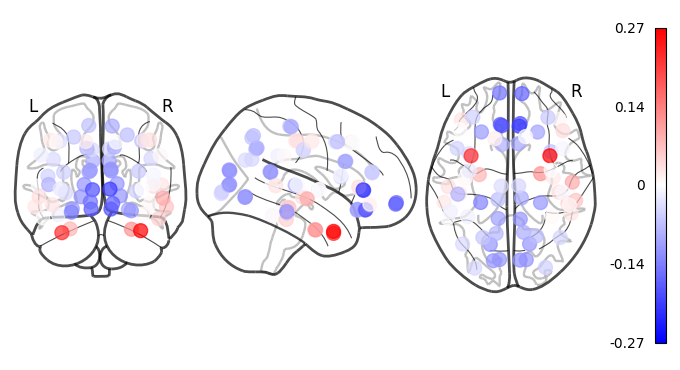

In [4]:
from utils.plots import generate_embedding_figures_68

encoder_path = 'best_EncoderClassifierFC_Language_Motor.pth'
avg_cam_language, avg_cam_motor = generate_avg_cam(dataset, GCN, encoder_path)
avg_cam_language_normalized = avg_cam_language/np.max(avg_cam_language)
avg_cam_motor_normalized = avg_cam_motor/np.max(avg_cam_motor)

generate_embedding_figures_68(avg_cam_language_normalized- avg_cam_motor_normalized)